In [63]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import plotly.express as px
from sklearn.metrics import mean_squared_error

In [64]:
path= r"C:\Users\Utente\Desktop\Various Datasets\household_power_consumption.txt"
df=pd.read_csv(path,delimiter=";")

C:\Users\Utente\AppData\Local\Temp\ipykernel_5168\4198537224.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(path,delimiter=";")


In [65]:
df['Global_active_power'].dtype
df=df[df.index<=900000]
df=df[['Date','Time','Global_active_power']]
df['Global_active_power']= pd.to_numeric(df['Global_active_power'], errors='coerce', downcast='float')

In [66]:
df['Global_active_power'].isna().sum()

3947

In [67]:
mean_usage=df['Global_active_power'].mean()   
df['Global_active_power']=df['Global_active_power'].fillna(0)

In [68]:
df['Global_active_power'].isna().sum()

0

In [69]:
df['Datetime']=df['Date']+' '+df['Time']
df.head()

,Date,Time,Global_active_power,Datetime
0,16/12/2006,17:24:00,4.216,16/12/2006 17:24:00
1,16/12/2006,17:25:00,5.360,16/12/2006 17:25:00
2,16/12/2006,17:26:00,5.374,16/12/2006 17:26:00
3,16/12/2006,17:27:00,5.388,16/12/2006 17:27:00
4,16/12/2006,17:28:00,3.666,16/12/2006 17:28:00


In [70]:
df=df.set_index(df['Datetime'])
df.index=pd.to_datetime(df.index)

In [71]:
test=df[(df.index>='2008-1-1') & (df.index<'2009-1-1')]
train=df[df.index<'2008-1-1']

In [72]:
df

,Date,Time,Global_active_power,Datetime
Datetime,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,16/12/2006 17:24:00
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,16/12/2006 17:25:00
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,16/12/2006 17:26:00
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,16/12/2006 17:27:00
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,16/12/2006 17:28:00
...,...,...,...,...
2008-01-09 17:20:00,1/9/2008,17:20:00,0.322,1/9/2008 17:20:00
2008-01-09 17:21:00,1/9/2008,17:21:00,0.320,1/9/2008 17:21:00
2008-01-09 17:22:00,1/9/2008,17:22:00,0.320,1/9/2008 17:22:00


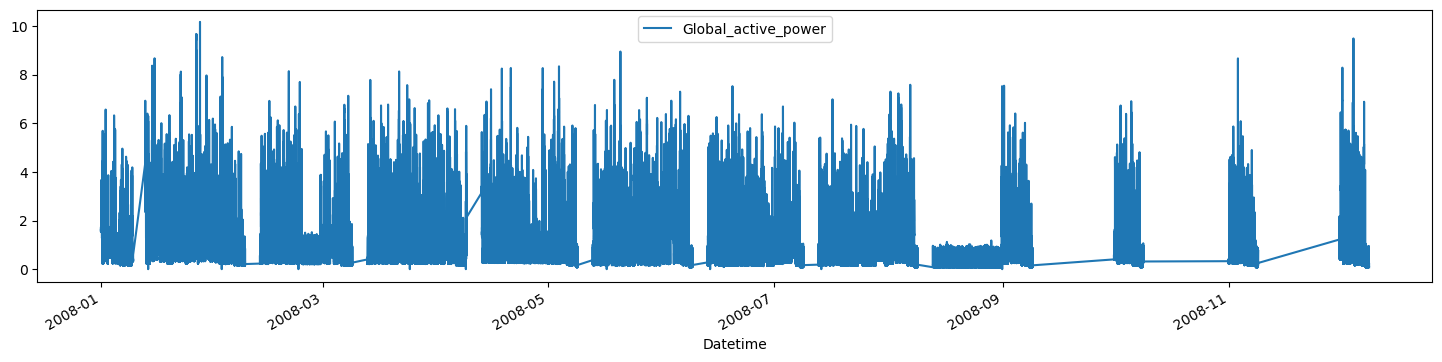

In [73]:

test.plot(figsize=(18,4))
plt.show()

In [74]:
def create_features(df):
    df=df.copy()
    df['month']=df.index.month
    df['quarter'] = df.index.quarter
    df['hour']=df.index.hour
    df['dayofyear']=df.index.dayofyear
    df['dayofmonth']=df.index.day
    df['dayofweek']=df.index.dayofweek
    df['weekoftheyear']=df.index.isocalendar().week
    return df
df=create_features(df)

In [75]:
df.head()

,Date,Time,Global_active_power,Datetime,month,quarter,hour,dayofyear,dayofmonth,dayofweek,weekoftheyear
Datetime,,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,16/12/2006 17:24:00,12,4,17,350,16,5,50
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,16/12/2006 17:25:00,12,4,17,350,16,5,50
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,16/12/2006 17:26:00,12,4,17,350,16,5,50
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,16/12/2006 17:27:00,12,4,17,350,16,5,50
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,16/12/2006 17:28:00,12,4,17,350,16,5,50


In [76]:
df['weekoftheyear']=df['weekoftheyear'].astype('int')

In [77]:
train = create_features(train)
test = create_features(test)

In [78]:
FEATURES = ['dayofyear', 'quarter','dayofweek','month','hour','dayofmonth']
TARGET = 'Global_active_power'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [79]:
model=xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=4,
                       learning_rate=0.025,
                       gamma=0.5)

In [80]:
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10)

[0]	validation_0-rmse:1.33285	validation_1-rmse:1.15636
[10]	validation_0-rmse:1.23065	validation_1-rmse:1.07849
[20]	validation_0-rmse:1.16240	validation_1-rmse:1.03019
[30]	validation_0-rmse:1.11698	validation_1-rmse:1.00015
[40]	validation_0-rmse:1.08666	validation_1-rmse:0.98185
[50]	validation_0-rmse:1.06463	validation_1-rmse:0.96661
[60]	validation_0-rmse:1.04806	validation_1-rmse:0.95630
[70]	validation_0-rmse:1.03494	validation_1-rmse:0.94968
[80]	validation_0-rmse:1.02489	validation_1-rmse:0.94513
[90]	validation_0-rmse:1.01702	validation_1-rmse:0.94118
[100]	validation_0-rmse:1.00991	validation_1-rmse:0.93826
[110]	validation_0-rmse:1.00360	validation_1-rmse:0.93520
[120]	validation_0-rmse:0.99730	validation_1-rmse:0.93320
[130]	validation_0-rmse:0.99278	validation_1-rmse:0.93150
[140]	validation_0-rmse:0.98830	validation_1-rmse:0.93010
[150]	validation_0-rmse:0.98389	validation_1-rmse:0.92913
[160]	validation_0-rmse:0.98043	validation_1-rmse:0.92868
[170]	validation_0-rmse:0

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.025, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

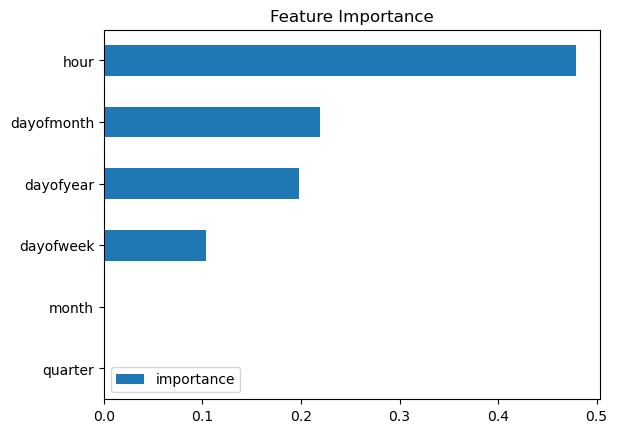

In [81]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [82]:
test['prediction'] = model.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)
df.head()

,Date,Time,Global_active_power,Datetime,month,quarter,hour,dayofyear,dayofmonth,dayofweek,weekoftheyear,prediction
Datetime,,,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,16/12/2006 17:24:00,12,4,17,350,16,5,50,NaN
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,16/12/2006 17:25:00,12,4,17,350,16,5,50,NaN
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,16/12/2006 17:26:00,12,4,17,350,16,5,50,NaN
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,16/12/2006 17:27:00,12,4,17,350,16,5,50,NaN
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,16/12/2006 17:28:00,12,4,17,350,16,5,50,NaN


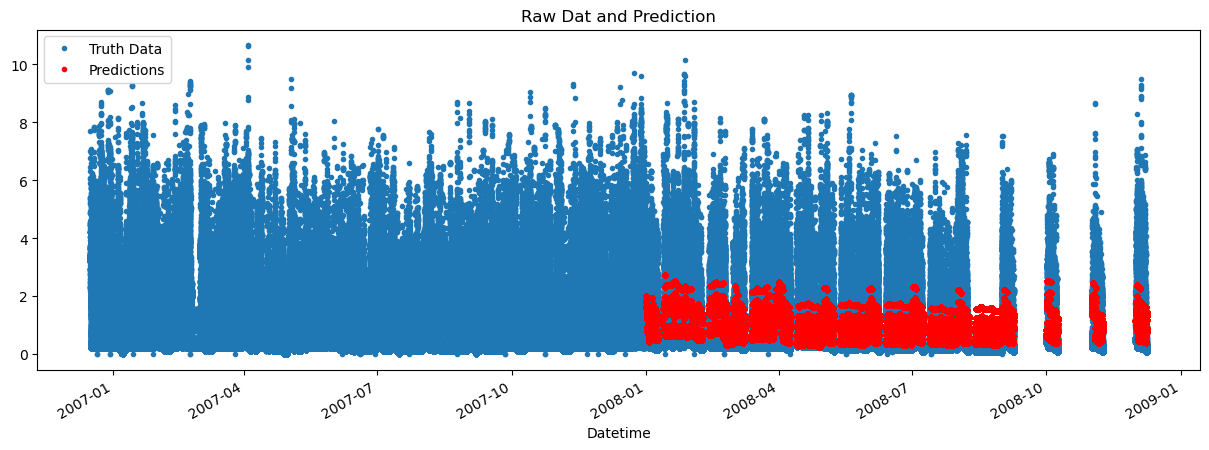

In [83]:
ax = df[['Global_active_power']].plot(figsize=(15, 5),style='.')
df['prediction'].plot(ax=ax, style='.',color='red')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

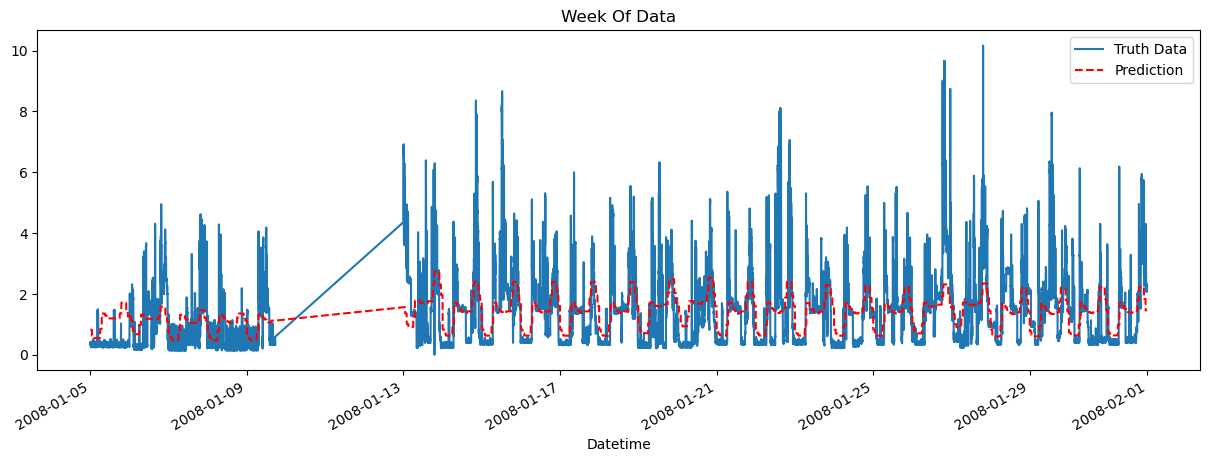

In [84]:
ax = df.loc[(df.index > '2008-01-05') & (df.index < '2008-02-1')]['Global_active_power'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2008-01-05') & (df.index < '2008-02-01')]['prediction'] \
    .plot(style='--',color='red')
plt.legend(['Truth Data','Prediction'])
plt.show()

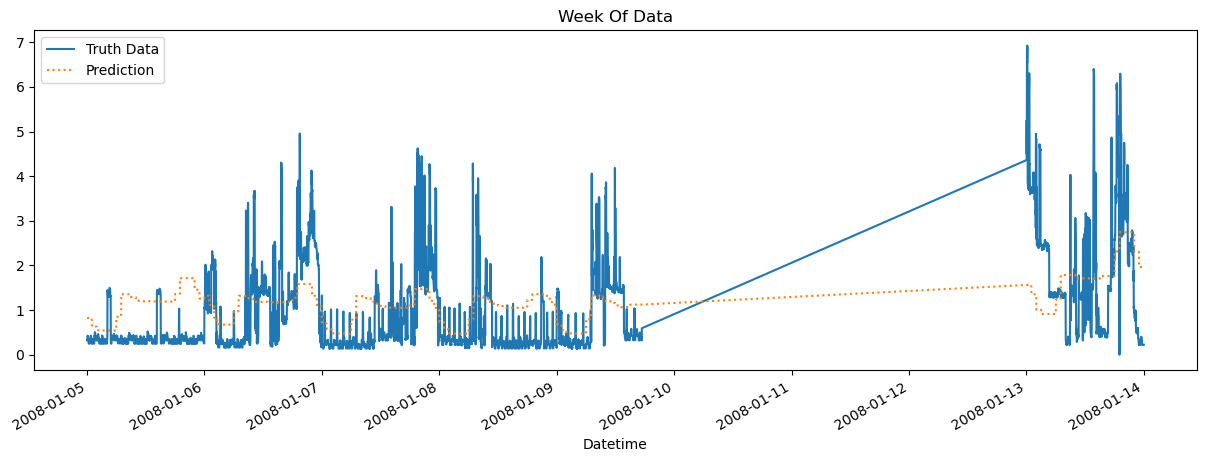

In [85]:
ax = df.loc[(df.index > '2008-01-05') & (df.index < '2008-01-14')]['Global_active_power'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2008-01-05') & (df.index < '2008-01-14')]['prediction'] \
    .plot(style=':')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [86]:
score = np.sqrt(mean_squared_error(test['Global_active_power'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.93


In [87]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2008-02-02    1.217216
2008-12-04    1.215537
2008-01-13    1.181672
2008-04-01    1.142701
2008-12-01    1.118763
2008-08-04    1.118547
2008-01-22    1.091571
2008-03-30    1.002593
2008-03-02    0.979476
2008-04-13    0.963411
Name: error, dtype: float32